# First we try and recreate the original Jursik and Kovac equation

In [210]:
import blink_util

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import RocCurveDisplay

data = pd.read_csv("Jurcsik_Kovacs_1996_table1.csv")


# data filter

df = data.drop(columns=["star_name","shifted_data","A0", "N"])



df

,period,sigma,A1,phi1,A2,phi2,A3,phi3,A4,phi4,...,phi11,A12,phi12,A13,phi13,a14,phi14,A15,phi15,metallicity
0,0.442266,0.0091,0.3218,0.0179,0.1803,2.6140,0.1057,5.4850,0.0590,2.0787,...,5.5635,0.0044,1.9820,0.0058,4.6203,0.0051,0.7701,0.0044,3.6286,-0.06
1,0.722753,0.0155,0.3358,1.6476,0.1720,5.9663,0.1134,4.0763,0.0617,2.5336,...,1.7614,0.0006,1.7596,0.0013,0.5223,0.0011,5.6820,0.0012,4.6372,-1.69
2,0.616915,0.0141,0.2000,1.5871,0.0795,5.8195,0.0399,3.9177,0.0192,2.1835,...,3.6049,0.0008,1.2567,0.0009,5.3117,0.0007,3.8731,0.0008,1.9359,-0.92
3,0.574337,0.0184,0.3241,2.9349,0.1425,1.9110,0.1110,1.1494,0.0745,0.5286,...,4.1754,0.0048,3.5231,0.0061,3.0121,0.0056,2.3907,0.0050,1.7239,-1.39
4,0.459303,0.0180,0.4646,1.8951,0.2167,6.0193,0.1610,4.1492,0.0980,2.3481,...,2.3529,0.0080,0.6458,0.0050,5.6980,0.0048,2.3401,0.0009,0.6272,-1.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0.557657,0.0135,0.3281,2.9453,0.1658,1.9827,0.1162,1.4013,0.0748,0.8343,...,4.8732,0.0038,4.3968,0.0046,3.8138,0.0050,3.2229,0.0051,2.6125,-1.15
80,0.475607,0.0139,0.3756,1.3720,0.2054,5.1373,0.1310,2.9590,0.0938,0.8321,...,3.3662,0.0046,0.6953,0.0034,4.6167,0.0018,2.0494,0.0011,5.7768,-0.60
81,0.525791,0.0377,0.4131,4.8677,0.1731,5.7203,0.1417,0.3700,0.1022,1.5990,...,2.7926,0.0102,3.8922,0.0096,5.0910,0.0088,0.0597,0.0077,1.3509,-1.54
82,0.656908,0.0184,0.2718,0.7286,0.1335,4.0737,0.0822,1.4576,0.0426,5.1255,...,0.8733,0.0028,4.4377,0.0014,1.3375,0.0010,4.4196,0.0009,1.7312,-1.02


# We now evaluate the relationship between parameters
We'll begin by setting up a new DF with the appropriate parameters

## $R_{mn}​=A_n/​A_m​​ $
We want the ratios between alphas as we don't want distance to affect our weights

In [ ]:
jk_df = pd.DataFrame() # This is the dataframe we'll use to replicate Jurcsik and Kovac's results with Phi31
jk_df["period"] = df["period"]


# Get amp ratios ex. A1/A2, A1/A3 etc.
alpha_filter = df.filter(["A1","A2","A3"])
for alpha in alpha_filter.columns:

    for alpha_denom in alpha_filter.drop(columns=[alpha]).columns:
        ratio_name = f"R_{alpha[1:]}{alpha_denom[1:]}"

        # append ratios
        jk_df[ratio_name] = alpha_filter[alpha].to_numpy() / alpha_filter[alpha_denom].to_numpy()

jk_df

,period,R_12,R_13,R_21,R_23,R_31,R_32
0,0.442266,1.784803,3.044465,0.560286,1.705771,0.328465,0.586245
1,0.722753,1.952326,2.961199,0.512210,1.516755,0.337701,0.659302
2,0.616915,2.515723,5.012531,0.397500,1.992481,0.199500,0.501887
3,0.574337,2.274386,2.919820,0.439679,1.283784,0.342487,0.778947
4,0.459303,2.143978,2.885714,0.466423,1.345963,0.346535,0.742963
...,...,...,...,...,...,...,...
79,0.557657,1.978890,2.823580,0.505334,1.426850,0.354160,0.700844
80,0.475607,1.828627,2.867176,0.546858,1.567939,0.348775,0.637780
81,0.525791,2.386482,2.915314,0.419027,1.221595,0.343016,0.818602
82,0.656908,2.035955,3.306569,0.491170,1.624088,0.302428,0.615730


## Computing $\phi_{n2n1}$
We get the values for Phi parameters to measure their weights

In [ ]:
phi_filter = df.filter(["phi1","phi2","phi3"])
for phi_n1 in phi_filter.columns:

    for phi_n2 in phi_filter.drop(columns=[phi_n1]).columns:
        phi_name = f"Phi{phi_n2[3:]}{phi_n1[3:]}"

        phi_n1_row = phi_filter[phi_n1].to_numpy()
        phi_n2_row = phi_filter[phi_n2].to_numpy()

        coef = int(phi_n2[3:])

        # append phase differences
        jk_df[phi_name] = blink_util.twopi_normalize(phi_n1_row, phi_n2_row, coef=coef)

jk_df["metallicity"] = df["metallicity"]

jk_df

,period,R_12,R_13,R_21,R_23,R_31,R_32,Phi21,Phi31,Phi12,Phi32,Phi13,Phi23,metallicity
0,0.442266,1.784803,3.044465,0.560286,1.705771,0.328465,0.586245,2.578200,5.431300,3.687085,3.926185,0.816085,4.210371,-0.06
1,0.722753,1.952326,2.961199,0.512210,1.516755,0.337701,0.659302,2.671100,5.416685,1.964485,5.026956,3.854485,4.096885,-1.69
2,0.616915,2.515723,5.012531,0.397500,1.992481,0.199500,0.501887,2.645300,5.439585,2.050785,5.308756,3.952585,4.267285,-0.92
3,0.574337,2.274386,2.919820,0.439679,1.283784,0.342487,0.778947,2.324385,4.911071,1.023900,1.699585,1.785500,5.895385,-1.39
4,0.459303,2.143978,2.885714,0.466423,1.345963,0.346535,0.742963,2.229100,4.747085,2.158985,4.940856,4.029085,4.004085,-1.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,0.557657,1.978890,2.823580,0.505334,1.426850,0.354160,0.700844,2.375285,5.131771,0.962600,1.736385,1.544000,5.463285,-1.15
80,0.475607,1.828627,2.867176,0.546858,1.567939,0.348775,0.637780,2.393300,5.126185,2.517885,0.113471,4.696185,5.502485,-0.60
81,0.525791,2.386482,2.915314,0.419027,1.221595,0.343016,0.818602,2.268085,4.616456,5.430585,2.058656,4.497700,4.980300,-1.54
82,0.656908,2.035955,3.306569,0.491170,1.624088,0.302428,0.615730,2.616500,5.554985,2.938085,1.802871,5.554185,1.158500,-1.02


# Finish up setting up the dataframe to recreate Jurcsik and Jovac's equation

In [ ]:
X = jk_df[["period", "Phi31"]]
y = jk_df["metallicity"] 

model = LinearRegression()

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=456)

model.fit(x_train, y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


# Display weight of each parameter

In [214]:
coefficients = model.coef_
intercept = model.intercept_


coef_df = pd.DataFrame({'Params': list(X), 'Coefficients':coefficients})
coef_df

#Creating a table of what predicted weights are being attahced to each independent variable.

,Params,Coefficients
0,period,-4.985851
1,Phi31,1.241911


We can see that the coefficients match up very close with the ones in the equation from Jurcsik and Kovac's paper `[Fe/H] = -5.038-5.394*P+1.345*phi31`

# Filter params

Mean Absolute Error (MEA): 0.1453861175667322
Mean Squared Error (MRE): 0.03715885428412163
R^2 Score: 0.9224739994640136


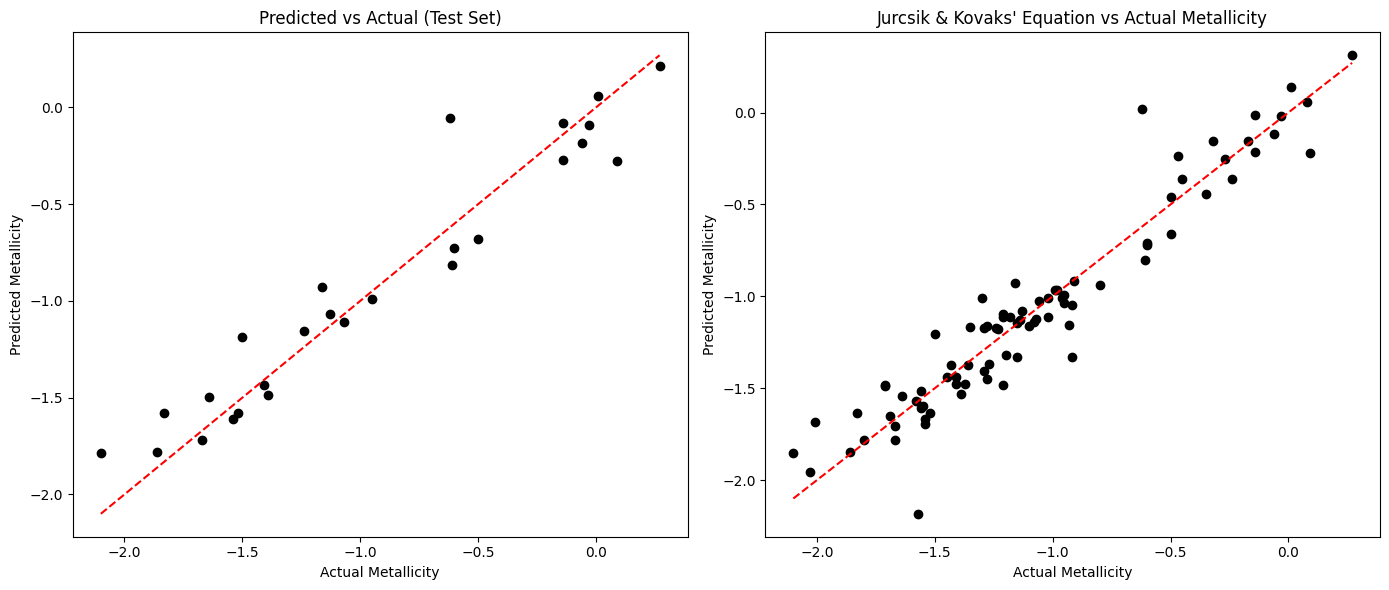

In [215]:
y_predict_test = model.predict(x_test)
y_predict_all = model.predict(X)

print(f"Mean Absolute Error (MEA): {mean_absolute_error(y_test, y_predict_test)}")

print(f"Mean Squared Error (MRE): {mean_squared_error(y_test, y_predict_test)}")

print(f"R^2 Score: {model.score(x_test, y_test)}")



fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(y_test, y_predict_test, color="black")
lims_test = [
    min(y_test.min(), y_predict_test.min()), max(y_test.max(), y_predict_test.max())
    ]
axes[0].plot(lims_test, lims_test, 'r--')
axes[0].set_xlabel("Actual Metallicity")
axes[0].set_ylabel("Predicted Metallicity")
axes[0].set_title("Predicted vs Actual (Test Set)")


Fe_on_H = blink_util.get_FoH(df, verbose=False)


axes[1].scatter(y, Fe_on_H, color="black")
lims_all = [min(y.min(), y_predict_all.min()), max(y.max(), y_predict_all.max())]
axes[1].plot(lims_all, lims_all, 'r--')
axes[1].set_xlabel("Actual Metallicity")
axes[1].set_ylabel("Predicted Metallicity")
axes[1].set_title("Jurcsik & Kovaks' Equation vs Actual Metallicity")

plt.tight_layout()
plt.show()

#Setting up Predicted vs. Actual for test data and the full set.

# Cross Validation
Here we use KFold and CV to measure the accuracy of the model

First we get the score for our first estimator

In [216]:
final_model = LinearRegression()

final_model.fit(X, y)



,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


Now we train our model using KFold splits with shuffled items and measure the scores

In [217]:
kfold = KFold(n_splits=5, shuffle=True)

scores = cross_val_score(final_model, X, y, cv=kfold, verbose=0)
r2_scores = cross_val_score(final_model, X, y, cv=kfold, scoring='r2')
mse_scores = -cross_val_score(final_model, X, y, cv=kfold, scoring='neg_mean_squared_error')

print(f"CV Scores: {scores}")
print("Cross-validated R^2 scores:", r2_scores)
print("Average R^2:", np.mean(r2_scores))
print("Cross-validated MSE:", mse_scores)
print("Average MSE:", np.mean(mse_scores))

CV Scores: [0.77415736 0.87594121 0.95751925 0.88513613 0.96427754]
Cross-validated R^2 scores: [0.96157726 0.69984257 0.85322462 0.93454226 0.91970239]
Average R^2: 0.873777820440725
Cross-validated MSE: [0.01238466 0.04167004 0.03215162 0.02843909 0.03258931]
Average MSE: 0.029446944652739337


# Equations

# 

In [218]:
#Attempt to get equation

m = model.coef_[0]      # slope
b = model.intercept_   # y-intercept

print(f"y = {m:.4f}x + {b:.4f}")

for i, coef in enumerate(model.coef_):
    print(f"b{i+1} = {coef}")

y = -4.9859x + -4.7216
b1 = -4.985851228516683
b2 = 1.2419108483380135
